<a href="https://colab.research.google.com/github/Schimidel/Sisbahia/blob/main/Analise_Dados_Correntes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Importa o google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Importa o pandas para ler a biblioteca
import pandas as pd

In [ ]:
#Lê a minha planilha do google sheets
url = 'https://docs.google.com/spreadsheets/d/1rskPNSp84J6bi194cn5T3Kg_osCpFUYCbXDZWoY5eeQ/export?format=csv&gid=1661275521' # Substitua 1234567890 pelo GID da sua segunda página
corrente_praticagem = pd.read_csv(url)

url = 'https://docs.google.com/spreadsheets/d/1rskPNSp84J6bi194cn5T3Kg_osCpFUYCbXDZWoY5eeQ/export?format=csv&gid=1546944652'
corrente_modelo = pd.read_csv(url)

In [ ]:
#Converte a coluna 'Date/Time' para datetime
corrente_praticagem['Date/Time'] = pd.to_datetime(corrente_praticagem['Date/Time'], format='%d/%m/%Y %H:%M:%S')
corrente_praticagem.rename(columns={'Date/Time': 'Time'}, inplace=True)
corrente_praticagem.set_index('Time')

#Resampleia por hora os dados, para fazer a análise no sisbahia
corrente_praticagem = corrente_praticagem.resample('h', on='Time').mean(numeric_only=True)

#Interpola valores nulos
corrente_praticagem = corrente_praticagem.interpolate()

In [ ]:
# Converte a coluna tempo para datetime
corrente_modelo['Tempo'] = pd.to_datetime(corrente_modelo['Tempo'], unit='s', origin='2024-02-25')

# Set 'Tempo' como índice
corrente_modelo = corrente_modelo.set_index('Tempo')

# Resample para frequência horária
corrente_modelo = corrente_modelo.resample('h').mean()

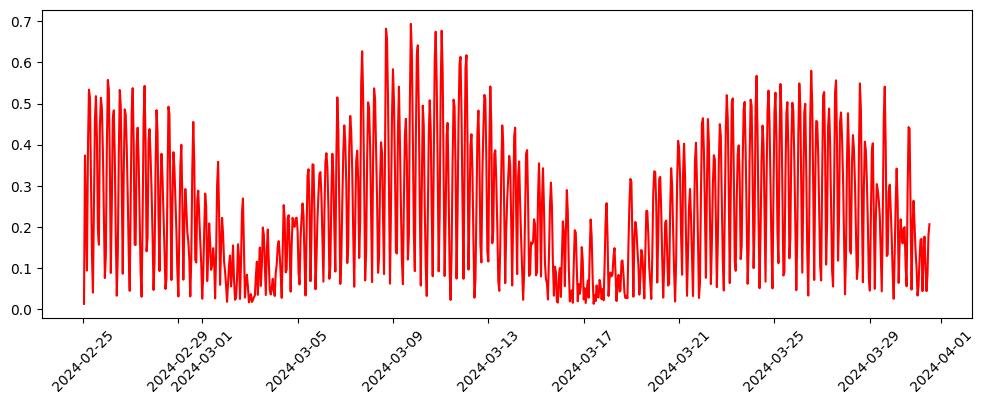

In [ ]:
#Plot velocidade do modelo
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.plot(corrente_modelo.index, corrente_modelo['Mod Vel'], c='red')
plt.xticks(rotation=45)
plt.show()

In [ ]:
#Coloca a intensidade da corrente de nós para m/s
corrente_praticagem.rename(columns={'Correntes [60m]_Intensidade da Corrente[nós]': 'Mod Vel'}, inplace=True)

In [ ]:
#Coloca a corrente praticagem em m/s
corrente_praticagem['Mod Vel'] = corrente_praticagem['Mod Vel'] / 1.94384

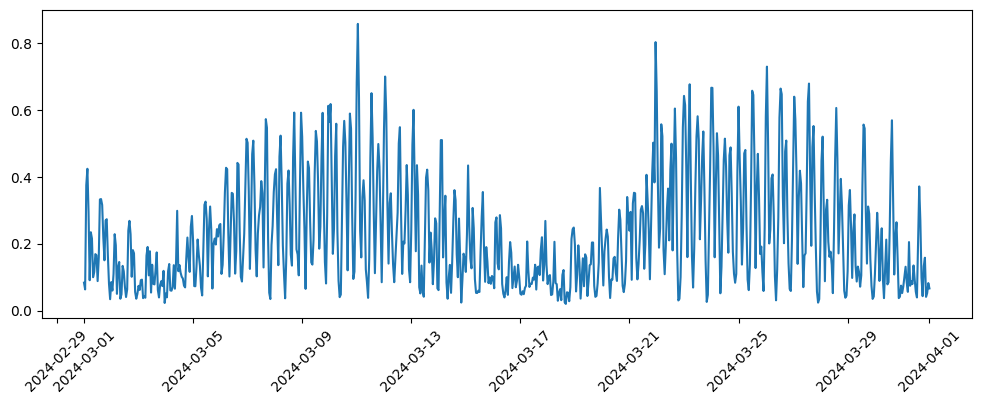

In [ ]:
#Plot velocidade da praticagem
plt.figure(figsize=(12,4))
plt.plot(corrente_praticagem.index, corrente_praticagem['Mod Vel'])
plt.xticks(rotation=45)
plt.show()

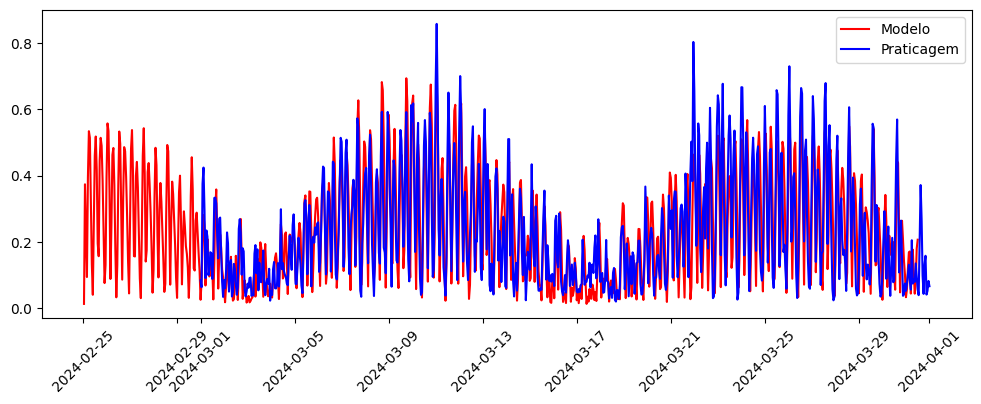

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.plot(corrente_modelo.index, corrente_modelo['Mod Vel'], c='red', label='Modelo')
plt.plot(corrente_praticagem.index, corrente_praticagem['Mod Vel'], c='blue', label='Praticagem')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [ ]:
import plotly.graph_objects as go

# Cria o gráfico interativo
fig = go.Figure()

# Adiciona a linha do modelo
fig.add_trace(go.Scatter(
    x=corrente_modelo.index,
    y=corrente_modelo['Mod Vel'],
    mode='lines',
    name='Modelo',
    line=dict(color='red')
))

# Adiciona a linha da praticagem
fig.add_trace(go.Scatter(
    x=corrente_praticagem.index,
    y=corrente_praticagem['Mod Vel'],
    mode='lines',
    name='Praticagem',
    line=dict(color='blue')
))

# Personaliza o layout do gráfico
fig.update_layout(
    title='Comparação entre Modelo e Praticagem',
    xaxis_title='Tempo',
    yaxis_title='Velocidade',
    legend_title='Legenda',
    xaxis_tickangle=-45,  # Rotaciona os rótulos do eixo x em -45 graus
    autosize=False,  # Desabilita o redimensionamento automático
    width=1200,  # Define a largura do gráfico
    height=400  # Define a altura do gráfico
)

# Exibe o gráfico interativo
fig.show()

In [ ]:
index_comum = corrente_praticagem.index.intersection(corrente_modelo.index)
corrente_praticagem = corrente_praticagem.loc[index_comum]
corrente_modelo = corrente_modelo.loc[index_comum]

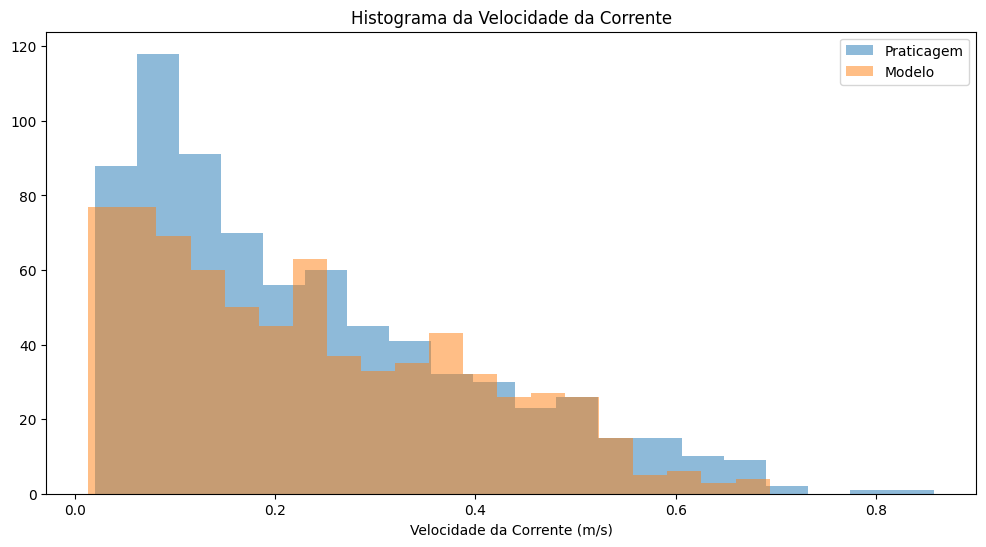

In [ ]:
# Define o tamanho da figura
plt.figure(figsize=(12, 6))

# Cria o histograma para 'corrente_praticagem'
plt.hist(corrente_praticagem['Mod Vel'], bins=20, alpha=0.5, label='Praticagem')

# Cria o histograma para 'corrente_modelo'
plt.hist(corrente_modelo['Mod Vel'], bins=20, alpha=0.5, label='Modelo')

#Adiciona os rótulos ao plot
plt.legend()

# Adiciona um título e rótulos aos eixos
plt.title('Histograma da Velocidade da Corrente')
plt.xlabel('Velocidade da Corrente (m/s)')
plt.show()

In [ ]:
#Calcula o RSME
import numpy as np

# Selecionar a variável de interesse
var1 = corrente_praticagem['Mod Vel']
var2 = corrente_modelo['Mod Vel']

# Calcular o RMSE
rmse = np.sqrt(np.mean((var1 - var2) ** 2))

print(f"O RMSE é: {rmse}")

O RMSE é: 0.11180413548972844


In [ ]:
# Cálculo do ICM
ICM = 100 * (1 - (np.sum(np.abs(var1 - var2)) / np.sum(np.abs(var1))))

# Resultados
print(f"ICM = {ICM:.2f}%")

ICM = 62.14%


In [ ]:
# Cálculo do ICE
ICE = 100 * (1 - np.abs(np.sum((var1**2) - (var2**2))) / np.sum(var1**2))

# Resultados
print(f"ICE = {ICE:.2f}%")

ICE = 97.16%


Equação da linha: y = 0.7340x + 0.0621
Coeficiente de correlação (R): 0.7659
Valor-p: 0.0000


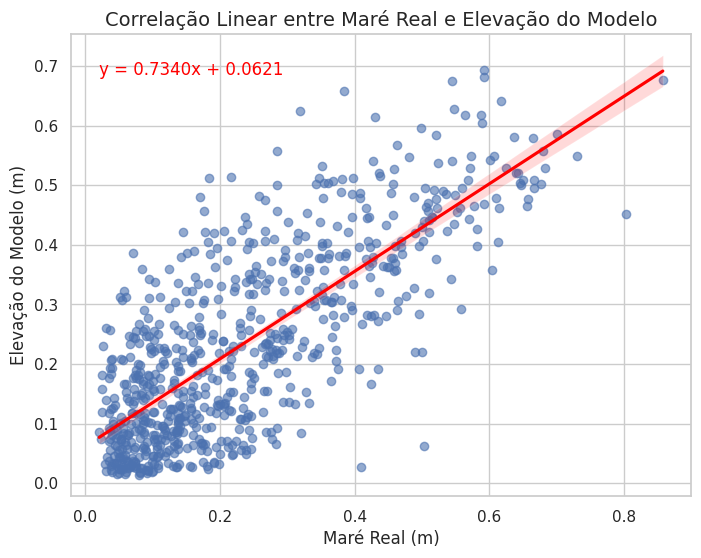

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Calcular os coeficientes da regressão linear
slope, intercept, r_value, p_value, std_err = linregress(var1, var2)

# Exibir a equação da linha de regressão
print(f"Equação da linha: y = {slope:.4f}x + {intercept:.4f}")
print(f"Coeficiente de correlação (R): {r_value:.4f}")
print(f"Valor-p: {p_value:.4f}")

# Criar o gráfico de dispersão com a linha de regressão
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.regplot(x=var1, y=var2, line_kws={"color": "red"}, scatter_kws={"alpha": 0.6})

# Adicionar a equação no gráfico
equation = f"y = {slope:.4f}x + {intercept:.4f}"
plt.text(x=min(var1), y=max(var2), s=equation, color="red", fontsize=12, ha="left", va="center")

# Personalizar o gráfico
plt.title("Correlação Linear entre Maré Real e Elevação do Modelo", fontsize=14)
plt.xlabel("Maré Real (m)", fontsize=12)
plt.ylabel("Elevação do Modelo (m)", fontsize=12)

# Exibir o gráfico
plt.show()